# Importing the modules

In [45]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import zipfile
import os 
import random
import cv2

# Extracting the files from the data folder and copying them into the designated folders

In [2]:
with zipfile.ZipFile('dogs-vs-cats.zip','r') as zip_ref:
    zip_ref.extractall('dataset')

In [3]:
with zipfile.ZipFile('dataset/train.zip','r') as zip_ref:
    zip_ref.extractall('train')

In [4]:
with zipfile.ZipFile('dataset/test1.zip','r') as zip_ref:
    zip_ref.extractall('test')

## Building a dataframe with the list of all training images and their labels 

In [5]:
filenames=os.listdir('train/train')
category=[]

for filename in filenames:
    if 'dog' in filename:
        category.append('dog')
    else:
        category.append('cat')

df={'filename':filenames,'category':category}
df=pd.DataFrame(df)

In [6]:
df.head()

,filename,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


## Opening a random image

In [7]:
any_file=random.choice(df.filename)
print(any_file)

dog.9293.jpg


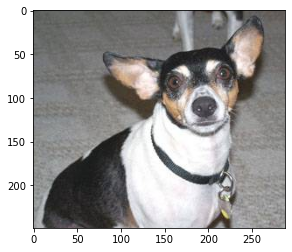

In [41]:
img=cv2.imread('train/train/'+str(any_file))
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

## Inorder to build a good model we need to check the size of each images and resize the images which we will do later

In [42]:
def checking_size(path,n=5):
    filenames=os.listdir(path)
    randomly_selected_files=[]
    sizes=[]
    for i in range(n):
        randomly_selected_files.append(random.choice(filenames))
    for j in randomly_selected_files:
        img=cv2.imread(path+'/'+str(j))
        sizes.append(img.shape)
    for k in range(len(sizes)):
        print(sizes[k])


In [43]:
checking_size('train/train')

(171, 320, 3)
(499, 412, 3)
(341, 415, 3)
(386, 350, 3)
(375, 499, 3)


In [44]:
checking_size('test/test1')

(407, 499, 3)
(374, 500, 3)
(375, 499, 3)
(500, 399, 3)
(459, 500, 3)


# Since the size of the images are very different we would be resizing them in a standard size of 64X64X3.


In [12]:
imageHeight=64
imageWidth=64
channels=3

# Creating the model

In [13]:
import tensorflow as tf 
from tensorflow.keras.layers import Input,Conv2D,BatchNormalization,MaxPooling2D,Dense,Dropout,GlobalMaxPooling2D,Flatten
from tensorflow.keras.models import Model

In [14]:
i=Input((imageHeight,imageWidth,channels))
x=Conv2D(32,(3,3),activation='relu',padding='same')(i)
x=BatchNormalization()(x)
x=Conv2D(32,(3,3),activation='relu',padding='same')(x)
x=BatchNormalization()(x)
x=MaxPooling2D((2,2))(x)

x=Conv2D(64,(3,3),activation='relu',padding='same')(x)
x=BatchNormalization()(x)
x=Conv2D(64,(3,3),activation='relu',padding='same')(x)
x=BatchNormalization()(x)
x=MaxPooling2D((2,2))(x)

x=Conv2D(128,(3,3),activation='relu',padding='same')(x)
x=BatchNormalization()(x)
x=Conv2D(128,(3,3),activation='relu',padding='same')(x)
x=BatchNormalization()(x)
x=GlobalMaxPooling2D()(x)
x=Dropout(0.2)(x)
x=Flatten()(x)
x=Dense(2056,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(2,activation='softmax')(x)

model=Model(i,x)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)       

# Dividing the dataset between training and validation set

In [15]:
from sklearn.model_selection import train_test_split
train_df,validation_df=train_test_split(df)
print(train_df.shape)
print(validation_df.shape)

(18750, 2)
(6250, 2)


# Building the training, validation and test generators

In [16]:
train_data_generator=tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,rescale=1/255,width_shift_range=0.1,
                                                                     height_shift_range=0.1,horizontal_flip=True)

train_data=train_data_generator.flow_from_dataframe(train_df,'train/train',x_col='filename',y_col='category',
                                                    target_size=(64,64),batch_size=32)

Found 18750 validated image filenames belonging to 2 classes.


In [17]:
validation_data_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

validation_data=validation_data_generator.flow_from_dataframe(validation_df,'train/train',x_col='filename',y_col='category',
                                                    target_size=(64,64),batch_size=32)

Found 6250 validated image filenames belonging to 2 classes.


In [18]:
test_filenames=os.listdir('test/test1')
test_df=pd.DataFrame(test_filenames,columns=['filename'])

In [19]:
test_df.head()

,filename
0,1.jpg
1,10.jpg
2,100.jpg
3,1000.jpg
4,10000.jpg


In [20]:
test_data_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
test_data=test_data_generator.flow_from_dataframe(test_df,'test/test1',x_col='filename',y_col=None,class_mode=None,
                                                    target_size=(64,64),batch_size=32)

Found 12500 validated image filenames.


# Compiling the model


In [21]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
r=model.fit(train_data,validation_data=validation_data,steps_per_epoch=train_df.shape[0]//32,batch_size=32,epochs=5)

Epoch 1/5
585/585 [==============================] - 600s 1s/step - loss: 0.7204 - accuracy: 0.6137 - val_loss: 0.5983 - val_accuracy: 0.6662
Epoch 2/5
585/585 [==============================] - 528s 903ms/step - loss: 0.5725 - accuracy: 0.7016 - val_loss: 0.5181 - val_accuracy: 0.7462
Epoch 3/5
585/585 [==============================] - 525s 898ms/step - loss: 0.4881 - accuracy: 0.7625 - val_loss: 0.5123 - val_accuracy: 0.7398
Epoch 4/5
585/585 [==============================] - 526s 899ms/step - loss: 0.4210 - accuracy: 0.8038 - val_loss: 0.4587 - val_accuracy: 0.7778
Epoch 5/5
585/585 [==============================] - 519s 887ms/step - loss: 0.3760 - accuracy: 0.8348 - val_loss: 0.3960 - val_accuracy: 0.8165


# Plotting Accuracy and Loss

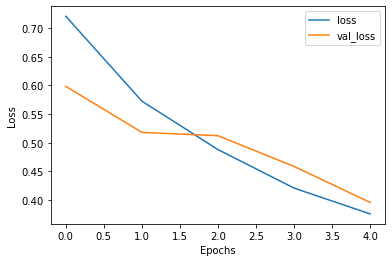

In [24]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

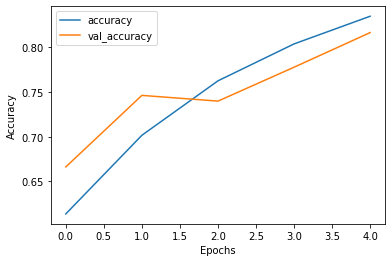

In [25]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

# Predicting the results

In [27]:
y_hat=model.predict(test_data)

In [32]:
y_pred=np.argmax(y_hat,axis=1)

In [34]:
test_df['label']=y_pred

In [35]:
test_df.head()

,filename,label
0,1.jpg,1
1,10.jpg,0
2,100.jpg,0
3,1000.jpg,0
4,10000.jpg,1


# Testing the checked result

In [38]:
def check_prediction():
    filename=test_df.filename
    filename=filename[:5]
    label=test_df.label
    label=label[:5]
    for i in range(len(filename)):
        img=cv2.imread('test/test1/'+filename[i])
        plt.imshow(img)
        plt.title(str(label[i]))
        plt.show()

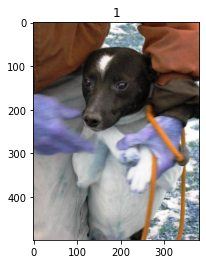

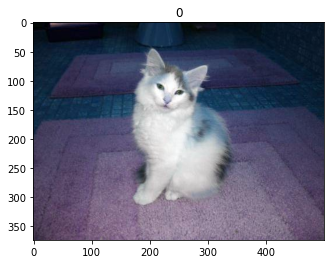

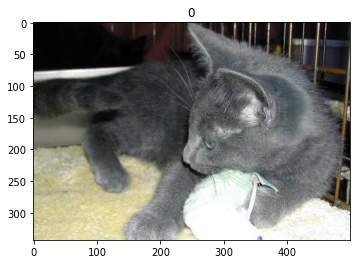

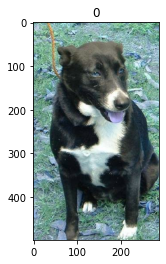

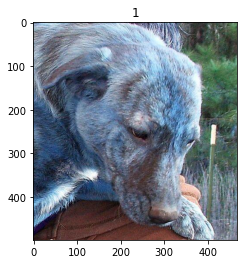

In [39]:
check_prediction()